# Retrieval transmission spectra

## Notebook setup

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import bz2
import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## Load

In [3]:
base_dir = "data/retrieval_tspec"

# Retrievals with lowest and highest log-evidences
fpaths_dict_extrema = {
    "K (clear)": f"{base_dir}/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_NofitR0_K",  # Worst
    "TiO (clear)": f"{base_dir}/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_NofitR0_TiO",  # Best
}
data_dict_extrema = {
    model_name: {
        "tspec": ascii.read(f"{model_dir}/retr_model.txt"),
        "tspec_sampled": ascii.read(
            f"{model_dir}/retr_model_sampled_Magellan_IMACS.txt"
        ),
        "retrieval": utils.load_pickle(f"{model_dir}/retrieval.pkl"),
    }
    for (model_name, model_dir) in fpaths_dict_extrema.items()
}

# Additional retreivals to compare overall shape
fpaths_dict = {
    "Na+K (clear)": f"{base_dir}/HATP23_E1_NoHet_FitP0_NoClouds_NoHaze_NofitR0_Na_K",
    "Na+K (cloud)": f"{base_dir}/HATP23_E1_NoHet_FitP0_Clouds_NoHaze_NofitR0_Na_K",
    "Na+K (haze)": f"{base_dir}/HATP23_E1_NoHet_FitP0_NoClouds_Haze_NofitR0_Na_K",
    "Na+K (spot)": f"{base_dir}/HATP23_E1_Het_FitP0_NoClouds_NoHaze_NofitR0_Na_K",
}
data_dict = {
    model_name: {
        "tspec": ascii.read(f"{model_dir}/retr_model.txt"),
        "tspec_sampled": ascii.read(
            f"{model_dir}/retr_model_sampled_Magellan_IMACS.txt"
        ),
        "retrieval": utils.load_pickle(f"{model_dir}/retrieval.pkl"),
    }
    for (model_name, model_dir) in fpaths_dict.items()
}

# Instrument data
instrument_dict = {
    "Magellan_IMACS": {
        "plot_kwargs": {
            "c": "w",
            "mec": "k",
            "fmt": "o",
            "ecolor": "k",
            "label": "Magellan/IMACS",
            "zorder": 10,
        },
        "data": ascii.read(f"{base_dir}/instrument/retr_Magellan_IMACS.txt"),
    }
}

## Plot

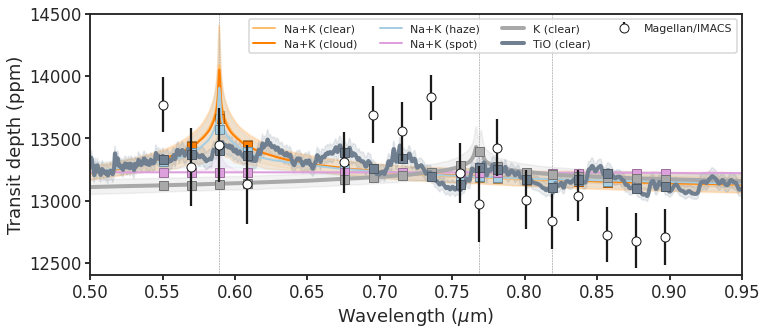

In [4]:
fig, ax = plt.subplots(figsize=FIG_WIDE)

# Sample models
colors = ["C0", "C1", "C2", "C4"]
for color, (model_name, model_dict) in zip(colors, data_dict.items()):
    p = utils.plot_model(
        ax,
        model_dict,
        model_kwargs={"lw": 2, "label": model_name},
        fill_kwargs={"color": color, "alpha": 0.15},
        sample_kwargs={"marker": "o"},
    )

# Best and worst models
colors = ["darkgrey", "C8"]
for color, (model_name, model_dict) in zip(colors, data_dict_extrema.items()):
    p = utils.plot_model(
        ax,
        model_dict,
        model_kwargs={"lw": 4, "label": model_name},
        fill_kwargs={"color": color, "alpha": 0.15},
        sample_kwargs={"marker": "o"},
    )

# Instruments
for (instrument_name, instrument_data) in instrument_dict.items():
    instrument_name = instrument_name.replace("_", "/")
    utils.plot_instrument(ax, instrument_data)

# Species
species = {
    "Na I-D": 5892.9,
    #'Hα':6564.6,
    "K I_avg": 7682.0,
    "Na I-8200_avg": 8189.0,
}
[
    ax.axvline(wav / 10000, lw=0.5, ls="--", color="grey", zorder=0)
    for name, wav in species.items()
]

# Save
ax.legend(loc=1, ncol=4, fontsize=11)
ax.set_xlim(0.5, 0.95)
ax.set_ylim(12_400, 14_500)
ax.set_xlabel(r"Wavelength $(\mu\mathrm{m})$")
ax.set_ylabel("Transit depth (ppm)")
fig.tight_layout()
fig.set_size_inches(FIG_WIDE)
utils.savefig("../paper/figures/retrieval_tspec/retrieval_tspec.pdf")

## Table

In [28]:
dfs = []
for model_name, model_data in data_dict_extrema.items():
    df_samples = pd.DataFrame(model_data["retrieval"]["samples"])
    df_stats = utils.get_table_stats(df_samples, columns=[model_name])
    dfs.append(df_stats)

for model_name, model_data in data_dict.items():
    df_samples = pd.DataFrame(model_data["retrieval"]["samples"])
    df_stats = utils.get_table_stats(df_samples, columns=[model_name])
    dfs.append(df_stats)

dfs[0], dfs[1] = dfs[1], dfs[0] # Show TiO column first
pd.concat(dfs, axis=1).fillna("--")#.to_clipboard()

,TiO (clear),K (clear),Na+K (clear),Na+K (cloud),Na+K (haze),Na+K (spot)
logP0,0.453^{+3.864}_{-4.256},3.416^{+1.865}_{-2.770},1.448^{+3.055}_{-3.120},0.750^{+3.424}_{-2.893},0.531^{+3.464}_{-3.065},-1.311^{+4.327}_{-3.178}
T,1751.066^{+782.909}_{-804.449},620.113^{+327.544}_{-208.875},1938.036^{+652.154}_{-779.129},1827.676^{+713.889}_{-950.206},1878.391^{+709.046}_{-972.777},1393.624^{+1043.456}_{-885.766}
logTiO,-7.116^{+4.000}_{-4.428},--,--,--,--,--
logK,--,-2.589^{+1.853}_{-2.742},-19.378^{+8.100}_{-7.350},-18.685^{+8.427}_{-7.660},-18.795^{+8.609}_{-7.427},-18.959^{+8.376}_{-7.199}
logNa,--,--,-3.985^{+2.824}_{-3.318},-3.929^{+2.754}_{-4.193},-4.787^{+3.341}_{-10.063},-15.466^{+9.382}_{-9.623}
logsigma_cloud,--,--,--,-37.705^{+9.910}_{-8.219},--,--
loga,--,--,--,--,-11.050^{+14.314}_{-12.691},--
gamma,--,--,--,--,-2.273^{+1.524}_{-1.219},--
Tocc,--,--,--,--,--,5906.755^{+348.598}_{-326.734}
Thet,--,--,--,--,--,2200.000^{+0.000}_{-0.000}
